# Conic Formulation of Unbalanced OT

Implement the linear programming formulation of unbalanced optimal transport as detailed in 

> [Optimal Entropy-Transport problems and a new Hellinger-Kantorovich distance between positive measures](https://arxiv.org/abs/1508.07941), Matthias Liero, Alexander Mielke, Giuseppe Savaré


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [4]:
def distmat(x,y):
    return np.sqrt( np.abs(np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y) ) )

# Unbalanced Wasserstein

In [58]:
n = 10
m = 11
k = 40 # angle samples
l = 41 

In [59]:
normalize = lambda a: a/np.sum(a)
# random histograms
a = normalize(np.random.rand(n))
b = normalize(np.random.rand(m))
# 1D histograms
def Gauss(x,m,s): return normalize( np.exp( -(x-m)**2 / (2*s**2) ) )
x = np.linspace(0,1,n)
y = np.linspace(0,1,m)
a = Gauss(x,.2,.1)
b = Gauss(y,.8,.1)

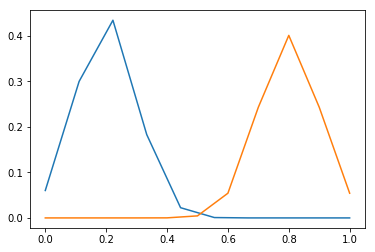

In [60]:
plt.plot(x,a)
plt.plot(y,b)

Discretized radius on the cones. TODO: select wisely `rmax`

In [61]:
rmax = np.sqrt( np.max(a) )
smax = np.sqrt( np.max(b) )
rlist = np.linspace(0,rmax,k)
slist = np.linspace(0,smax,l)

Define the conic cost for Gaussian-Hellinger with penalty $\tau$ on the marginals
$$
    C(x,r,y,s) \triangleq r^2 + s^2 - 2rs e^{ - d(x,y)^2 /\tau }
$$

In [65]:
tau = 1
D = distmat(x[None,:],y[None,:])
# Wasserstein-Fisher-Rao
def WFR(r,s,d): return r**2+s**2 - 2*r*s*np.cos( np.minimum(d/tau, np.pi/2) )
# Gaussian Hellinger
def GH(r,s,d): return r**2+s**2 - 2*r*s*np.exp( -d**2/(2*tau) )
#
C = GH( rlist[None,:,None,None], slist[None,None,None,:], D[:,None,:,None] )
C = np.reshape(C, (n*k,m*l))

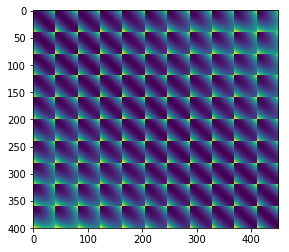

In [66]:
plt.imshow(C)

Conic unbalanced Wasserstein problem
$$
    \min_{\alpha \geq 0} \{ \langle \alpha,C \rangle :
        \sum_{k,j,\ell} \alpha_{i,k,j,l} r_{k}^2 = a_i, 
        \sum_{i,k,\ell} \alpha_{i,k,j,l} s_{\ell}^2 = b_j. 
    \}
$$

In [67]:
Rlist = np.tile(rlist, (n,1))
Slist = np.tile(slist, (m,1))
# variable
alpha = cp.Variable((n*k,m*l))
alpha1 = cp.Variable((n,k))
alpha2 = cp.Variable((m,l))
# constraints
U = [0 <= alpha, 
#        alpha1==cp.reshape(cp.sum(alpha, axis=1),(n,k)), \ # BUG!!
#        alpha2==cp.reshape(cp.sum(alpha, axis=0),(m,l)), \ # BUG!!
        alpha1==cp.reshape(cp.sum(alpha, axis=1),(k,n)).T, \
        alpha2==cp.reshape(cp.sum(alpha, axis=0),(l,m)).T, \
        cp.sum( cp.multiply(alpha1, Rlist**2), 1)==a, \
        cp.sum( cp.multiply(alpha2, Slist**2), 1)==b \
    ]
# solve using CVXPY
objective = cp.Minimize( cp.sum(cp.multiply(alpha,C)) )
prob = cp.Problem(objective, U)
result = prob.solve(verbose=True)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +5.469e-01  +5.469e-01  +2e+05  1e+00  9e-01  1e+00  1e+00    ---    ---    1  2  - |  -  - 
 1  -4.610e+00  -1.361e+00  +9e+04  4e-02  1e-01  3e+00  5e-01  0.9890  4e-01   2  2  2 |  0  0
 2  -1.978e+00  -1.527e+00  +6e+03  2e-03  5e-03  5e-01  3e-02  0.9706  3e-02   2  2  2 |  0  0
 3  -1.082e+00  -1.079e+00  +5e+02  5e-04  4e-04  3e-03  3e-03  0.9075  5e-03   1  2  2 |  0  0
 4  +1.046e-01  +1.053e-01  +1e+02  2e-04  5e-05  7e-04  7e-04  0.8048  5e-02   1  2  2 |  0  0
 5  +1.064e-01  +1.070e-01  +1e+02  2e-04  5e-05  6e-04  7e-04  0.0939  8e-01   1  2  1 |  0  0
 6  +2.431e-01  +2.433e-01  +6e+01  1e-04  2e-05  2e-04  3e-04  0.6453  2e-01   1  2  2 |  0  0
 7  +2.445e-01  +2.446e-01  +6e+01  1e-04  2e-05  2e-04  3e-04  0.1085  8e-01   1  1  1 |  0  0
 8  +2.788e-01  +2.789e-01  +3e+01  9e-05  1e-

Sanity checking that constraint are indeed enforced.

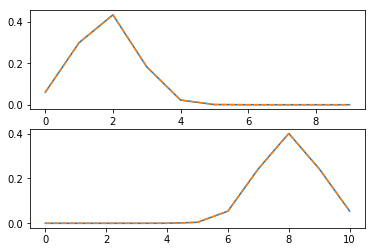

In [68]:
Alpha1 = np.reshape(alpha1.value,(n,k))
Alpha2 = np.reshape(alpha2.value,(m,l))
#
plt.subplot(2,1,1)
plt.plot( np.sum(Alpha1 * rlist[None,:]**2,1) )
plt.plot(a, '--')
plt.subplot(2,1,2)
plt.plot( np.sum(Alpha2 * slist[None,:]**2,1) )
plt.plot(b, '--')

In [69]:
Alpha = np.reshape(alpha.value,(n,k,m,l))
#
B = np.sum(np.sum(Alpha,axis=2,keepdims=True),axis=3,keepdims=True)
B = np.squeeze(B)
print( np.linalg.norm( B - Alpha1 ) )
# 
B = np.sum(np.sum(Alpha,axis=0,keepdims=True),axis=1,keepdims=True)
B = np.squeeze(B)
print( np.linalg.norm( B - Alpha2 ) )

5.050450251008603e-11
2.0432810879732128e-11


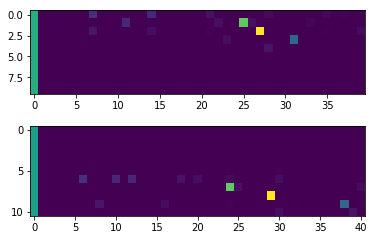

In [70]:
plt.subplot(2,1,1)
plt.imshow( alpha1.value )
plt.subplot(2,1,2)
plt.imshow( alpha2.value )

Compute from the conic solution $\alpha$, the solution $\pi$ of the log-entropic problem for the Gaussian-Hellinger problem
$$
    \min_\pi \langle pi, D^2 \rangle + \tau \text{KL}(\pi_1|a) + \tau \text{KL}(\pi_2|b)
$$

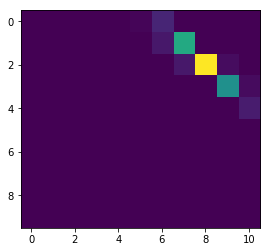

In [75]:
def dilation(r,s,d): return np.sqrt( r*s*np.exp( -d**2/(2*tau) ) )
eta = dilation( rlist[None,:,None,None], slist[None,None,None,:], D[:,None,:,None] )
# multiply by eta^2 and then marginalize on (x,y)
pi = np.sum( np.sum( Alpha * eta**2, 1, keepdims=True), 3, keepdims=True).squeeze()
plt.imshow(pi)

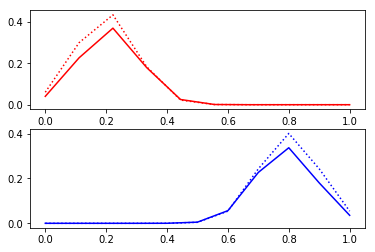

In [76]:
plt.subplot(2,1,1)
plt.plot(x,np.sum(pi,1), 'r')
plt.plot(x,a, 'r:')
plt.subplot(2,1,2)
plt.plot(y,np.sum(pi,0), 'b')
plt.plot(y,b, 'b:')

Compare against Sinkhorn.

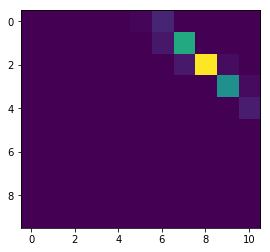

In [73]:
def mina_u(H,epsilon): return -epsilon*np.log( np.sum(a[:,None] * np.exp(-H/epsilon),0) )
def minb_u(H,epsilon): return -epsilon*np.log( np.sum(b[None,:] * np.exp(-H/epsilon),1) )
def mina(H,epsilon): return mina_u(H-np.min(H,0),epsilon) + np.min(H,0);
def minb(H,epsilon): return minb_u(H-np.min(H,1)[:,None],epsilon) + np.min(H,1);
epsilon = .001
kappa = tau/(tau+epsilon)
# cost 
C1 = D**2
# sinkhorn
f = np.zeros(n)
niter = 1000
for it in range(niter):
    g = kappa*mina(C1-f[:,None],epsilon)
    f = kappa*minb(C1-g[None,:],epsilon)
# generate the coupling
pi1 = a[:,None] * np.exp((f[:,None]+g[None,:]-C1)/epsilon) * b[None,:]

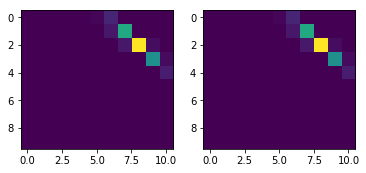

In [81]:
plt.subplot(1,2,1)
plt.imshow(pi)
plt.subplot(1,2,2)
plt.imshow(pi1)

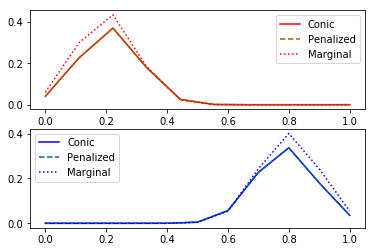

In [79]:
plt.subplot(2,1,1)
plt.plot(x,np.sum(pi,1), '-', color=(1,0,0), label='Conic')
plt.plot(x,np.sum(pi1,1), '--', color=(.6,.4,0), label='Penalized')
plt.plot(x,a, 'r:', label='Marginal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(y,np.sum(pi,0), '-', color=(0,0,1), label='Conic')
plt.plot(y,np.sum(pi1,0), '--', color=(0,.4,.6), label='Penalized')
plt.plot(y,b, 'b:', label='Marginal')
plt.legend()

# Check bug in reshaping
It appears that there is a bug and that CVXPY is reshaping differently from Numpy!!

` np.reshape(X,(n,p)) == cp.reshape(X,(p,n)).T `

In [23]:
A = np.random.rand(3,4)
# variable
B1 = cp.Variable((3*4))
objective = cp.Minimize( cp.norm(A-cp.reshape(B1,(3,4)) ) )
prob = cp.Problem(objective, U)
result = prob.solve(verbose=False)
B = np.reshape(B1.value,(3,4)) # not working
B = np.reshape(B1.value,(4,3)).T # not working
# 
np.linalg.norm(B-A)

1.1974989921953674e-08